# Train deepRetina

In [1]:
# A bit of setup
import numpy as np
from scipy.io import loadmat
import os.path as path
import matplotlib.pyplot as plt
from nems.utilities import rolling_window
from lnl_model_functions import *
from matplotlib.pyplot import *
from pyret.filtertools import getsta, filterpeak # input: (time,), stim (x,x,x,time), spikes (times,)
import pyret.visualizations as viz # note that this imports seaborn and messes up all plotting functions
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import mpld3

# from time import time
# import re
# from os import listdir
# from os.path import isfile, join
# from scipy import misc
# import scipy.io


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


# Load data

#### Use normalized float32 stim

In [2]:
data_dir = '/Users/lmcintosh/Git/deepRGC/datasets/white_noise/'
metadata = np.load(path.join(data_dir, 'metadata.npz'))['metadata'].item()
stim  = np.memmap(path.join(data_dir, 'stim_norm.dat'), dtype=metadata['stim_norm_dtype'], 
                  mode='r', shape=metadata['stim_norm_shape'])
rates = np.memmap(path.join(data_dir, 'rates.dat'), dtype=metadata['rates_dtype'], 
                  mode='r', shape=metadata['rates_shape'])

### Smooth raw spike count with 10 ms std Gaussian to get PSTHs

In [3]:
rates_filt = np.zeros(rates.shape)
filt       = gaussian(x=np.linspace(-5,5,10), sigma=1, mu=0)
for cell in xrange(rates.shape[1]):
    rates_filt[:,cell] = np.convolve(rates[:,cell], filt, mode='same')

### Create 4d stim array where each data point is a 400ms (40 frame) movie

<matplotlib.colorbar.Colorbar instance at 0x3e06f0d88>

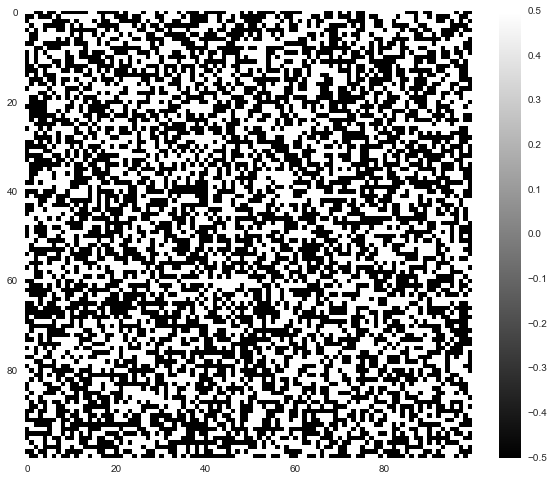

In [4]:
imshow(stim[:,:,0])
grid(False)
colorbar()

In [5]:
#stim_sliced = stim[34:-34, 34:-34,:]
stim_sliced = stim[52:64, 36:48]

In [6]:
X = rolling_window(stim_sliced, 40)
X = np.rollaxis(X, 2)
X = np.rollaxis(X, 3, 1)

In [7]:
X.shape

(299850, 40, 12, 12)

In [8]:
X.T.shape

(12, 12, 40, 299850)

### Truncate rates to appropriate time frame

In [9]:
y = rates_filt[X.shape[1]:]

### Show STA as sanity check that data looks right

In [10]:
cell = 9 # good center cells are 0, 5, 7. high fr cells are 3, 7, 8, 9

In [11]:
np.mean(y[:,cell] > 0)

0.31550108387527098

## STA on filtered rates

In [12]:
def sta(stimulus, spiketrain):
    if len(spiketrain.shape) > 1:
        sta = {}
        for cell in xrange(spiketrain.shape[1]):
            sta[cell] = np.zeros(stimulus[0].shape)
            for spi, sp in enumerate(spiketrain[:,cell]):
                if spi % 100000 == 0:
                        print spi
                        
                if sp == 0:
                    pass
                else:
                    sta[cell] += sp * stimulus[spi]
            sta[cell] /= len(spiketrain[:,cell] > 0)
            print cell
        return sta
            
    else:
        sta = np.zeros(stimulus[0].shape)
        for spi, sp in enumerate(spiketrain):
            if spi % 100000 == 0:
                    print spi

            if sp == 0:
                pass
            else:
                sta += sp * stimulus[spi]
        sta /= len(spiketrain > 0)
        return sta
        
#         numSpikes = len(spiketrain)
#         sta = np.dot(stimulus.T, spiketrain)
#         sta /= numSpikes
#         return sta.T    

In [13]:
X_sta = sta(X, y[:,cell])

0
100000
200000


## Alternate STA function for passing in random indices

In [14]:
def sta_memmap(indices, stim_memmap, spiketrain):
    """ spiketrain is size (indices,)
    """
    sta = np.zeros(stim_memmap[0].shape)
    for spi, sp in enumerate(spiketrain):
        if spi % 100000 == 0:
                print spi

        if sp == 0:
            pass
        else:
            sta += sp * stim_memmap[indices[spi]]
    sta /= len(spiketrain > 0)
    return sta

<matplotlib.colorbar.Colorbar instance at 0x3e0d56cf8>

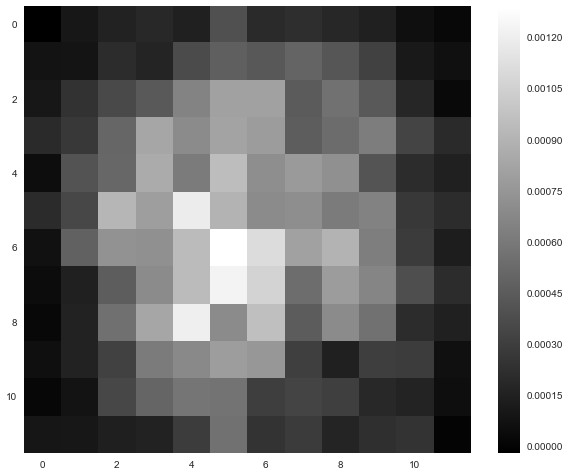

In [15]:
imshow(X_sta[33,:,:])
grid(False)
colorbar()

In [16]:
peaks = filterpeak(X_sta.T)

In [17]:
peaks

((5, 6, 33), array([6, 5]), 33)

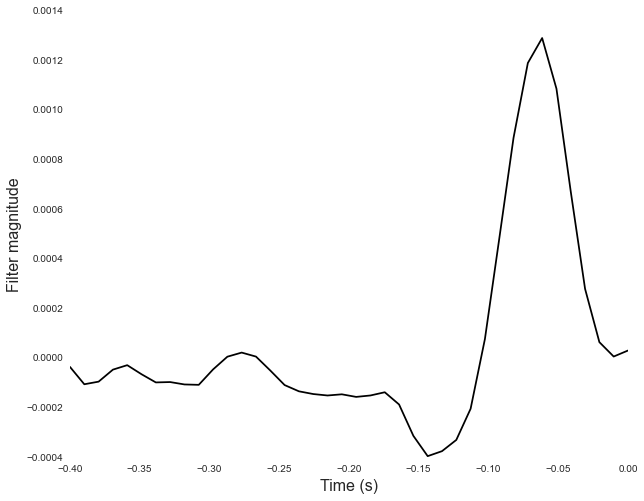

In [18]:
times = np.linspace(-0.01*X_sta.shape[0], 0, X_sta.shape[0])
plot(times, X_sta[:,peaks[1][0],peaks[1][1]], 'k')
xlim([np.min(times), 0])
xlabel('Time (s)', fontsize=16)
ylabel('Filter magnitude', fontsize=16)

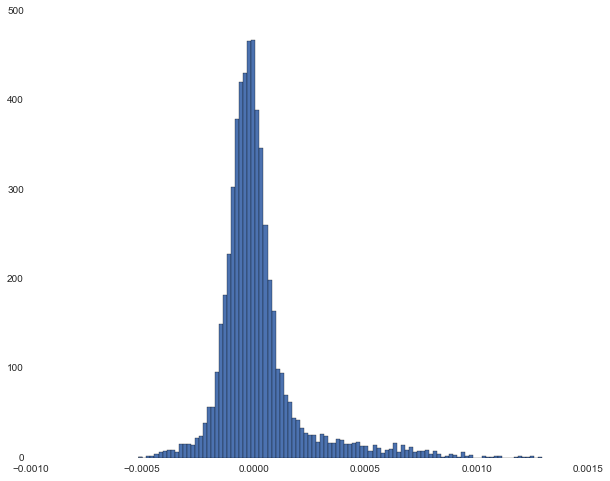

In [19]:
count, bins, h = hist(X_sta.flat, 100)

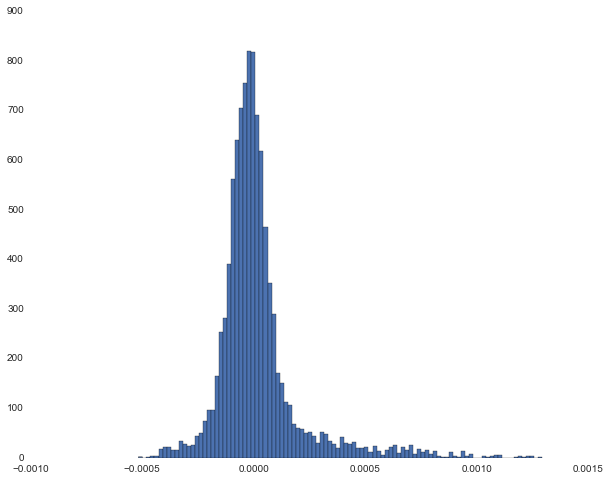

In [77]:
_,_,_ = hist(np.random.choice(X_sta.flat, 10000, replace=True), 100)

# Train a 2 layer convnet

In [306]:
from utils.classifiers.convnet import init_two_layer_convnet
from utils.classifiers.convnet import two_layer_convnet

In [307]:
model = init_two_layer_convnet(input_shape=X[0].shape, num_classes=1, filter_size=9, 
                               num_filters=16, weight_scale=10e-5) # weight_scale=0.015

### Work on subset of the total data

In [308]:
cell = cell

# Divide examples into training, validation, and test sets
numTrain = 50000
numVal   = 500
numTest  = 500

drawIndices = np.random.choice(X.shape[0], size=(numTrain+numVal+numTest), replace=False)
trainMask = drawIndices[:numTrain]
valMask   = drawIndices[numTrain:-numTest]
testMask  = drawIndices[-numTest:]

# don't need to zero mean data since we loaded stim_norm

In [300]:
X[trainMask].shape

(50000, 40, 12, 12)

In [23]:
X[valMask].shape

(1000, 40, 32, 32)

In [24]:
X[testMask].shape

(1000, 40, 32, 32)

In [25]:
y[:,cell][valMask].shape

(1000,)

### Memmap test

In [ ]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 5e-5
reg = 0.0 #0.001
dropout = 1.0
num_epochs = 5

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


#best_model = None
#best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train_memmap(X, y[:,cell], trainMask, 
                                                                                  valMask, model, two_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=500, verbose=True,
                                                                                 acc_frequency=5, save_plots=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

In [293]:
tmp = model.copy()

In [302]:
tmp2 = model.copy()

In [282]:
model['W1'][0][30].shape

(9, 9)

<matplotlib.colorbar.Colorbar instance at 0x3e78b8cf8>

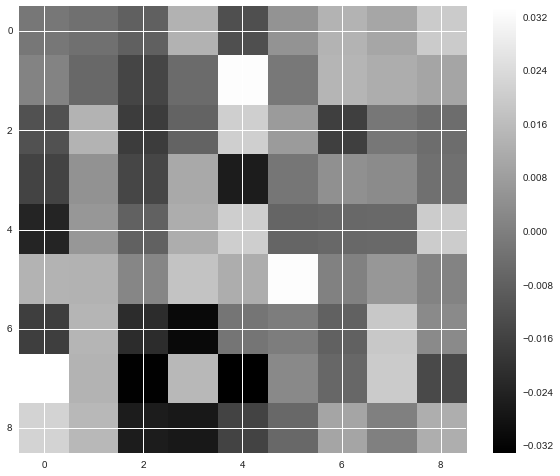

In [289]:
imshow(model['W1'][5][30])
colorbar()

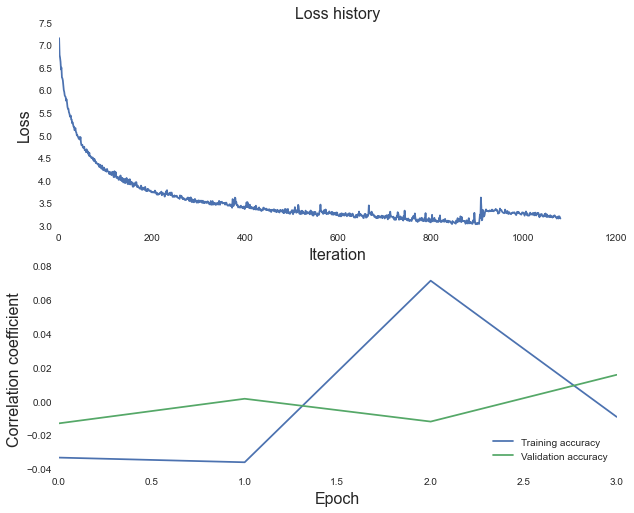

In [236]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)

# Train a 3 layer convnet

In [ ]:
from utils.classifiers.convnet import init_three_layer_convnet
from utils.classifiers.convnet import three_layer_convnet

In [ ]:
model = init_three_layer_convnet(input_shape=X[0].shape, num_classes=1, filter_size=9, 
                               num_filters=(16, 32), weight_scale=10e-5) # weight_scale=0.015

### Work on subset of the total data

In [ ]:
cell = cell

# Divide examples into training, validation, and test sets
numTrain = 50000
numVal   = 500
numTest  = 500

drawIndices = np.random.choice(X.shape[0], size=(numTrain+numVal+numTest), replace=False)
trainMask = drawIndices[:numTrain]
valMask   = drawIndices[numTrain:-numTest]
testMask  = drawIndices[-numTest:]

# don't need to zero mean data since we loaded stim_norm

In [ ]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 5e-6
reg = 0.0 #0.001
dropout = 1.0
num_epochs = 2

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


#best_model = None
#best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train_memmap(X, y[:,cell], trainMask, 
                                                                                  valMask, model, three_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=50, verbose=True,
                                                                                 acc_frequency=5, save_plots=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)